In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2
import math
from numpy.fft import fft2, fftshift, ifft2 # Python DFT

In [3]:
def equalise_histogram(img, elements, frequency):
    
    cumu_freq = np.zeros((len(frequency),),dtype=int)
    output = np.zeros((len(frequency),),dtype=int)
    new_pixelmap = np.zeros((img.width, img.height), dtype=int)
    
    levels = len(frequency) -1
    size = img.width * img.height
    
    cumu_freq[0]= frequency[0]
    val = round((levels/size)* cumu_freq[0])
    output[0] = val
    
    for i in range(1,len(frequency)):
        cumu_freq[i]= frequency[i] + cumu_freq[i-1]
        val = round((levels/size)* cumu_freq[i])
        output[i] = val
    
    w,h = img.size
    pixelmap = img.load()

    
    for i in range(0,w):
        for j in range(0,h):
            val = pixelmap[i,j]
            index = elements.index(val)
            new_pixelmap[i][j] += output[index]
        
        
    plt.gray()
    plt.imshow(np.rot90(new_pixelmap), cmap='gray',origin='lower')
    plt.yticks([])
    plt.xticks([])
    plt.savefig('Eq.jpg')
    
    return  output,new_pixelmap         
    

In [4]:
def normal_histogram(img):    
    
    pixelmap = list(img.getdata())
    elements = list(set(pixelmap))
    
    frequency = np.zeros((len(elements),),dtype=int)
  
    for i in range(len(elements)):   
        val = pixelmap.count(elements[i])
        frequency[i] = val
    frequency= list(frequency)
    return elements, frequency

In [5]:
def create_histogram(xaxis, yaxis,name):
    
    figure, axes = plt.subplots(figsize=(20, 20))
    axes.bar(xaxis,yaxis, width=0.8, tick_label = xaxis, color= 'purple')
    axes.set_ylabel( 'Count Per Intensity',size=20)
    axes.set_xlabel('Image Intensities' , size=20)
    for i, v in enumerate(yaxis):
          plt.text(xaxis[i]-0.4, v+0.01, str(v))
    figure.savefig(name+'.jpg')

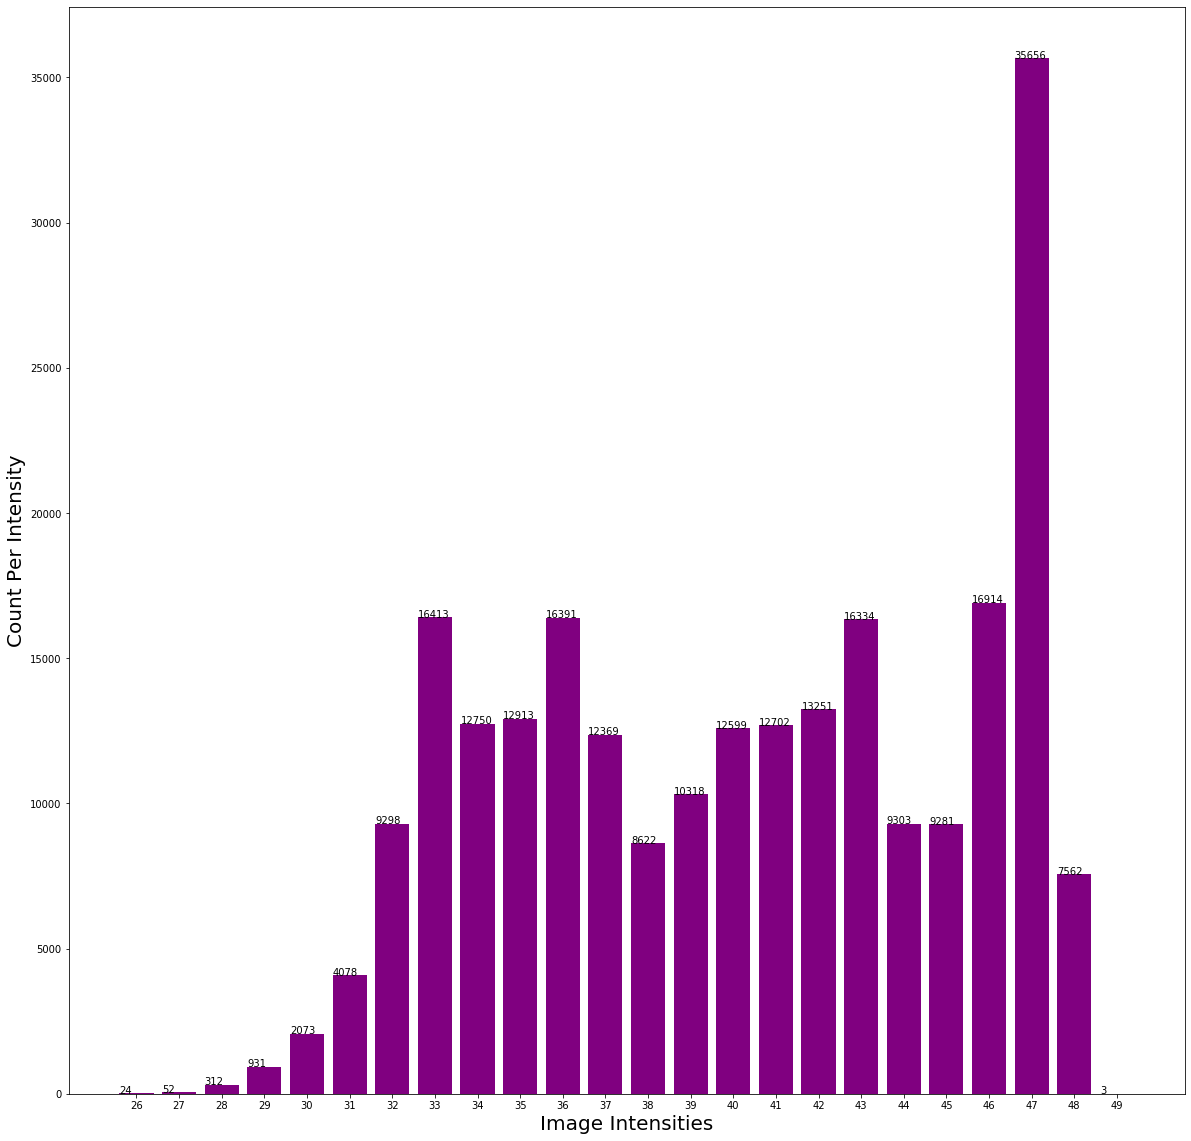

In [6]:
image = Image.open('Sphinx.png').convert('L')
new_img = image.copy()
elements, normal_vector = normal_histogram(new_img)
create_histogram(elements, normal_vector,'Before_Eq')

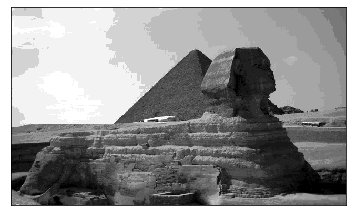

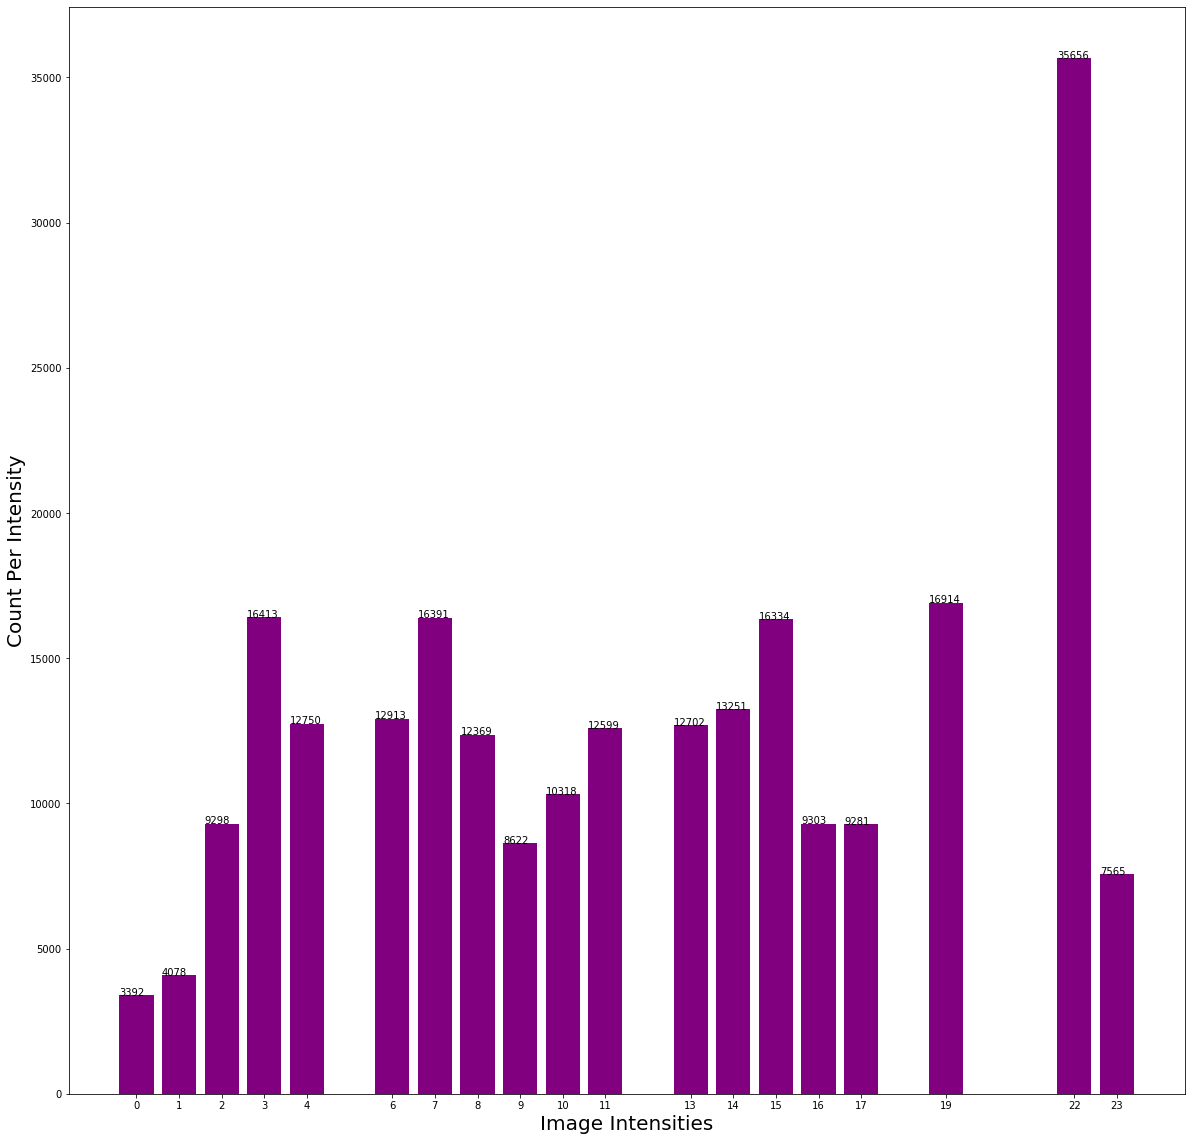

In [7]:
equalised_vector,imgArray = equalise_histogram(new_img, elements, normal_vector)
#equalised_img= Image.open('Eq.jpg').convert('L')
#lements, normal_vector = normal_histogram(equalised_img)


newImageAfterEq=Image.fromarray(imgArray)
elements1, normal_vector1 = normal_histogram(newImageAfterEq)
create_histogram(elements1,normal_vector1,'After_Eq')

In [8]:
# def plot_eq_histogram(normal_vector, equalised_vector):
#     xaxis = np.unique(equalised_vector)
#     yaxis= np.zeros((len(xaxis)), dtype = int)
                    
#     for index in range(0,equalised_vector.shape[0]):
        
#         x_value = equalised_vector[index]
#         added_freq = normal_vector[index]
#         y_index = np.where(xaxis == x_value)
#         yaxis[y_index]+= added_freq
        
#     print("xaxis", xaxis)
#     print("yaxis", yaxis)
        
#     figure, axes = plt.subplots(figsize=(20, 10))

#     axes.bar(xaxis,yaxis, width=0.9, tick_label = xaxis, color= 'purple')
#     axes.set_ylabel('Newly Added Frequency',size=10)
#     axes.set_xlabel('Image Intensities', size=10)
#     for i, v in enumerate(yaxis):
#           plt.text(xaxis[i]-0.4, v+0.01, str(v))   
#     #plt.savefig('After_Eq.jpg')

# plot_eq_histogram(normal_vector,equalised_vector )

        

In [9]:
def applyHighBoost(A,n,img,D0,fileName):
    
    f = np.fft.fftshift(img)
    magnitude_spectrum= np.fft.fft2(f)
    
    highBoostFilter=np.zeros((magnitude_spectrum.shape[0], magnitude_spectrum.shape[1]))

    Mdivided2 = int(magnitude_spectrum.shape[0]/2)
    Ndivided2 = int(magnitude_spectrum.shape[1]/2)

    for i in range(0,magnitude_spectrum.shape[0]):
        for j in range(0,magnitude_spectrum.shape[1]):

            distanceDUV = math.sqrt(math.pow((i-Mdivided2),2) + math.pow((j-Ndivided2),2))
            if(i==Mdivided2 and j==Ndivided2):
                highPathButterWorth = 1
            else:
                highPathButterWorth = 1 / ( 1 + (math.pow(( D0 / distanceDUV),(2*n))))

            highBoostVal = highPathButterWorth + (A-1)

            # HIGH BOOST FILTER VALUES 
            highBoostFilter[i][j]= highBoostVal
   
    m = magnitude_spectrum * highBoostFilter
    
    imageArray=np.fft.ifft2(m) 

    imageArray=imageArray.real

    imageArrayshift=np.fft.ifftshift(imageArray)
    
    cv2.imwrite(fileName+'.jpg', imageArrayshift) 

       
    return 

In [10]:
img = cv2.imread('Moon.jpg',0)
applyHighBoost(2,2,img,50,'MoonHB_3')

In [11]:
img = cv2.imread('Moon.jpg',0)
applyHighBoost(2,1,img,50,'MoonHB_2')

In [12]:
img = cv2.imread('Moon.jpg',0)
applyHighBoost(1.5,1,img,50,'MoonHB_1')